In [1]:
# import libraries
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from torchsummary import summary

In [2]:
import sys
sys.path.append("../")
sys.path.append("../../")

import os
import random
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from predict import predict
from open_data import open_data, create_global_batch,get_df_stats,apply_norm
from dataset import RadarDataset,RadarCollate
from encoder_decoder_clean import lstm_seq2seq
from simple_model import LSTM
from train import train

In [17]:
PATH_CSV="/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv" #"/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'
DAYS_INPUT=7
WINDOW_LABEL=1
INPUT_SIZE=(DAYS_INPUT)*24*4
OUTPUT_SIZE=(WINDOW_LABEL)*24*4
TOTAL_DAYS=365

In [18]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [19]:
df1

,global_date,Volume,Day of Week,date
0,2018-01-01 00:00:00,54,1,2018-01-01
1,2018-01-01 00:15:00,39,1,2018-01-01
2,2018-01-01 00:30:00,89,1,2018-01-01
3,2018-01-01 00:45:00,98,1,2018-01-01
4,2018-01-01 01:00:00,80,1,2018-01-01
...,...,...,...,...
29238,2018-12-30 19:00:00,165,0,2018-12-30
29239,2018-12-30 19:15:00,170,0,2018-12-30
29240,2018-12-30 19:30:00,133,0,2018-12-30
29241,2018-12-30 19:45:00,129,0,2018-12-30


In [20]:
batch_df=create_global_batch(df1, window_x_day=DAYS_INPUT, window_label_day=WINDOW_LABEL, gap_acquisition=1, tot_len_day=TOTAL_DAYS)

Building batch 0 
 x begin 2018-01-02 label begin 2018-01-09 end period 2018-12-22 
Building batch 1 
 x begin 2018-01-03 label begin 2018-01-10 end period 2018-12-22 
Building batch 2 
 x begin 2018-01-04 label begin 2018-01-11 end period 2018-12-22 
Building batch 3 
 x begin 2018-01-05 label begin 2018-01-12 end period 2018-12-22 
We do not have all the dates for the time period in label , 96 42
Building batch 3 
 x begin 2018-01-06 label begin 2018-01-13 end period 2018-12-22 
Building batch 3 
 x begin 2018-01-07 label begin 2018-01-14 end period 2018-12-22 
Building batch 3 
 x begin 2018-01-08 label begin 2018-01-15 end period 2018-12-22 
Building batch 3 
 x begin 2018-01-09 label begin 2018-01-16 end period 2018-12-22 
Building batch 3 
 x begin 2018-01-10 label begin 2018-01-17 end period 2018-12-22 
Building batch 3 
 x begin 2018-01-11 label begin 2018-01-18 end period 2018-12-22 
Building batch 3 
 x begin 2018-01-12 label begin 2018-01-19 end period 2018-12-22 
Building b

Building batch 40 
 x begin 2018-03-31 label begin 2018-04-07 end period 2018-12-22 
Building batch 40 
 x begin 2018-04-01 label begin 2018-04-08 end period 2018-12-22 
We do not have all the dates for the time period in x , 672 654
Building batch 40 
 x begin 2018-04-02 label begin 2018-04-09 end period 2018-12-22 
Building batch 41 
 x begin 2018-04-03 label begin 2018-04-10 end period 2018-12-22 
Building batch 42 
 x begin 2018-04-04 label begin 2018-04-11 end period 2018-12-22 
Building batch 43 
 x begin 2018-04-05 label begin 2018-04-12 end period 2018-12-22 
Building batch 44 
 x begin 2018-04-06 label begin 2018-04-13 end period 2018-12-22 
Building batch 45 
 x begin 2018-04-07 label begin 2018-04-14 end period 2018-12-22 
Building batch 46 
 x begin 2018-04-08 label begin 2018-04-15 end period 2018-12-22 
Building batch 47 
 x begin 2018-04-09 label begin 2018-04-16 end period 2018-12-22 
Building batch 48 
 x begin 2018-04-10 label begin 2018-04-17 end period 2018-12-22 
B

 x begin 2018-06-26 label begin 2018-07-03 end period 2018-12-22 
Building batch 86 
 x begin 2018-06-27 label begin 2018-07-04 end period 2018-12-22 
Building batch 87 
 x begin 2018-06-28 label begin 2018-07-05 end period 2018-12-22 
Building batch 88 
 x begin 2018-06-29 label begin 2018-07-06 end period 2018-12-22 
Building batch 89 
 x begin 2018-06-30 label begin 2018-07-07 end period 2018-12-22 
Building batch 90 
 x begin 2018-07-01 label begin 2018-07-08 end period 2018-12-22 
Building batch 91 
 x begin 2018-07-02 label begin 2018-07-09 end period 2018-12-22 
Building batch 92 
 x begin 2018-07-03 label begin 2018-07-10 end period 2018-12-22 
Building batch 93 
 x begin 2018-07-04 label begin 2018-07-11 end period 2018-12-22 
Building batch 94 
 x begin 2018-07-05 label begin 2018-07-12 end period 2018-12-22 
Building batch 95 
 x begin 2018-07-06 label begin 2018-07-13 end period 2018-12-22 
Building batch 96 
 x begin 2018-07-07 label begin 2018-07-14 end period 2018-12-22 

Building batch 127 
 x begin 2018-09-26 label begin 2018-10-03 end period 2018-12-22 
Building batch 128 
 x begin 2018-09-27 label begin 2018-10-04 end period 2018-12-22 
Building batch 129 
 x begin 2018-09-28 label begin 2018-10-05 end period 2018-12-22 
Building batch 130 
 x begin 2018-09-29 label begin 2018-10-06 end period 2018-12-22 
Building batch 131 
 x begin 2018-09-30 label begin 2018-10-07 end period 2018-12-22 
Building batch 132 
 x begin 2018-10-01 label begin 2018-10-08 end period 2018-12-22 
Building batch 133 
 x begin 2018-10-02 label begin 2018-10-09 end period 2018-12-22 
Building batch 134 
 x begin 2018-10-03 label begin 2018-10-10 end period 2018-12-22 
Building batch 135 
 x begin 2018-10-04 label begin 2018-10-11 end period 2018-12-22 
Building batch 136 
 x begin 2018-10-05 label begin 2018-10-12 end period 2018-12-22 
Building batch 137 
 x begin 2018-10-06 label begin 2018-10-13 end period 2018-12-22 
Building batch 138 
 x begin 2018-10-07 label begin 20

In [21]:
batch_df

,vol_data_x,vol_label_y
0,"[22.0, 13.0, 21.0, 21.0, 15.0, 11.0, 19.0, 5.0...","[66, 40, 40, 22, 28, 22, 13, 9, 10, 14, 17, 7,..."
1,"[33.0, 31.0, 20.0, 22.0, 13.0, 13.0, 13.0, 9.0...","[36, 32, 28, 26, 23, 20, 14, 21, 8, 9, 11, 9, ..."
2,"[32.0, 31.0, 25.0, 29.0, 29.0, 10.0, 21.0, 17....","[48, 32, 36, 28, 32, 23, 8, 22, 17, 7, 21, 15,..."
3,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38, 38, 26, 21, 26, 22, 18, 11, 2, 4, 8, 6, 1..."
4,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35, 35, 35, 23, 23, 14, 13, 13, 8, 6, 9, 9, 6..."
...,...,...
170,"[39, 31, 27, 14, 10, 9, 9, 16, 12, 9, 9, 4, 10...","[54, 31, 33, 34, 16, 15, 12, 15, 10, 13, 10, 3..."
171,"[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ..."
172,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,..."
173,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ..."


In [22]:
#batch_df["mean_x"]=batch_df["vol_data_x"].apply(lambda x : np.mean(x))
#batch_df["std_x"]=batch_df["vol_data_x"].apply(lambda x : np.std(x))
#batch_df["mean_y"]=batch_df["vol_label_y"].apply(lambda x : np.mean(x))
# batch_df

In [23]:
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)


In [24]:
get_df_stats(new_data,["vol_data_x_norm","vol_label_y_norm"])

(0.0, 1.0)

In [25]:
batch_df

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[22.0, 13.0, 21.0, 21.0, 15.0, 11.0, 19.0, 5.0...","[66, 40, 40, 22, 28, 22, 13, 9, 10, 14, 17, 7,...",0.0,870.0,4.0,474.0,"[0.022610483042137718, 0.013360739979445015, 0...","[0.06783144912641316, 0.041109969167523124, 0....",0.000000,0.894142,0.004111,0.487153
1,"[33.0, 31.0, 20.0, 22.0, 13.0, 13.0, 13.0, 9.0...","[36, 32, 28, 26, 23, 20, 14, 21, 8, 9, 11, 9, ...",0.0,870.0,2.0,470.0,"[0.03391572456320658, 0.03186022610483042, 0.0...","[0.03699897225077081, 0.0328879753340185, 0.02...",0.000000,0.894142,0.002055,0.483042
2,"[32.0, 31.0, 25.0, 29.0, 29.0, 10.0, 21.0, 17....","[48, 32, 36, 28, 32, 23, 8, 22, 17, 7, 21, 15,...",0.0,870.0,5.0,477.0,"[0.0328879753340185, 0.03186022610483042, 0.02...","[0.04933196300102775, 0.0328879753340185, 0.03...",0.000000,0.894142,0.005139,0.490236
3,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38, 38, 26, 21, 26, 22, 18, 11, 2, 4, 8, 6, 1...",0.0,789.0,2.0,481.0,"[0.013360739979445015, 0.0051387461459403904, ...","[0.03905447070914697, 0.03905447070914697, 0.0...",0.000000,0.810894,0.002055,0.494347
4,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35, 35, 35, 23, 23, 14, 13, 13, 8, 6, 9, 9, 6...",0.0,505.0,5.0,635.0,"[0.03494347379239465, 0.029804727646454265, 0....","[0.03597122302158273, 0.03597122302158273, 0.0...",0.000000,0.519013,0.005139,0.652621
...,...,...,...,...,...,...,...,...,...,...,...,...
170,"[39, 31, 27, 14, 10, 9, 9, 16, 12, 9, 9, 4, 10...","[54, 31, 33, 34, 16, 15, 12, 15, 10, 13, 10, 3...",4.0,487.0,3.0,488.0,"[0.040082219938335044, 0.03186022610483042, 0....","[0.05549845837615622, 0.03186022610483042, 0.0...",0.004111,0.500514,0.003083,0.501542
171,"[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ...",3.0,488.0,4.0,484.0,"[0.045220966084275435, 0.03597122302158273, 0....","[0.03905447070914697, 0.03597122302158273, 0.0...",0.003083,0.501542,0.004111,0.497431
172,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,...",3.0,488.0,5.0,501.0,"[0.05960945529290853, 0.02877697841726619, 0.0...","[0.0421377183967112, 0.04316546762589928, 0.03...",0.003083,0.501542,0.005139,0.514902
173,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ...",3.0,501.0,6.0,480.0,"[0.051387461459403906, 0.041109969167523124, 0...","[0.06474820143884892, 0.05344295991778006, 0.0...",0.003083,0.514902,0.006166,0.493320


In [26]:
new_data

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[22.0, 13.0, 21.0, 21.0, 15.0, 11.0, 19.0, 5.0...","[66, 40, 40, 22, 28, 22, 13, 9, 10, 14, 17, 7,...",0.0,870.0,4.0,474.0,"[0.022610483042137718, 0.013360739979445015, 0...","[0.06783144912641316, 0.041109969167523124, 0....",0.000000,0.894142,0.004111,0.487153
1,"[33.0, 31.0, 20.0, 22.0, 13.0, 13.0, 13.0, 9.0...","[36, 32, 28, 26, 23, 20, 14, 21, 8, 9, 11, 9, ...",0.0,870.0,2.0,470.0,"[0.03391572456320658, 0.03186022610483042, 0.0...","[0.03699897225077081, 0.0328879753340185, 0.02...",0.000000,0.894142,0.002055,0.483042
2,"[32.0, 31.0, 25.0, 29.0, 29.0, 10.0, 21.0, 17....","[48, 32, 36, 28, 32, 23, 8, 22, 17, 7, 21, 15,...",0.0,870.0,5.0,477.0,"[0.0328879753340185, 0.03186022610483042, 0.02...","[0.04933196300102775, 0.0328879753340185, 0.03...",0.000000,0.894142,0.005139,0.490236
3,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38, 38, 26, 21, 26, 22, 18, 11, 2, 4, 8, 6, 1...",0.0,789.0,2.0,481.0,"[0.013360739979445015, 0.0051387461459403904, ...","[0.03905447070914697, 0.03905447070914697, 0.0...",0.000000,0.810894,0.002055,0.494347
4,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35, 35, 35, 23, 23, 14, 13, 13, 8, 6, 9, 9, 6...",0.0,505.0,5.0,635.0,"[0.03494347379239465, 0.029804727646454265, 0....","[0.03597122302158273, 0.03597122302158273, 0.0...",0.000000,0.519013,0.005139,0.652621
...,...,...,...,...,...,...,...,...,...,...,...,...
170,"[39, 31, 27, 14, 10, 9, 9, 16, 12, 9, 9, 4, 10...","[54, 31, 33, 34, 16, 15, 12, 15, 10, 13, 10, 3...",4.0,487.0,3.0,488.0,"[0.040082219938335044, 0.03186022610483042, 0....","[0.05549845837615622, 0.03186022610483042, 0.0...",0.004111,0.500514,0.003083,0.501542
171,"[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ...",3.0,488.0,4.0,484.0,"[0.045220966084275435, 0.03597122302158273, 0....","[0.03905447070914697, 0.03597122302158273, 0.0...",0.003083,0.501542,0.004111,0.497431
172,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,...",3.0,488.0,5.0,501.0,"[0.05960945529290853, 0.02877697841726619, 0.0...","[0.0421377183967112, 0.04316546762589928, 0.03...",0.003083,0.501542,0.005139,0.514902
173,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ...",3.0,501.0,6.0,480.0,"[0.051387461459403906, 0.041109969167523124, 0...","[0.06474820143884892, 0.05344295991778006, 0.0...",0.003083,0.514902,0.006166,0.493320


In [27]:
#get_df_stats(new_data,columns=["vol_data_x_norm","vol_label_y_norm"])

In [28]:
# sample_rate = 16000
batch_size = 1

In [31]:
#normalize=transforms.Compose([
#    transforms.ToTensor(),
  #  transforms.Normalize(mean=[df_mean],
                       #  std=[df_std])
#])
fullset = RadarDataset(dataframe=batch_df,transform=None)
ptrain,pval,ptest=0.8,0.05,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest,shuffle=False)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest),shuffle=False)

(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,

In [32]:
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [33]:
print(traindataset)

[(array([0.02261048, 0.01336074, 0.02158273, 0.02158273, 0.01541624,
       0.01130524, 0.01952724, 0.00513875, 0.01438849, 0.0061665 ,
       0.00513875, 0.00822199, 0.004111  , 0.00719424, 0.01130524,
       0.00924974, 0.00822199, 0.00822199, 0.01336074, 0.02261048,
       0.02980473, 0.03494347, 0.03905447, 0.05755396, 0.08119219,
       0.10174717, 0.12846865, 0.22610483, 0.21891059, 0.2672148 ,
       0.32271326, 0.40390545, 0.41315519, 0.35149024, 0.44604317,
       0.36176773, 0.45940391, 0.35662898, 0.34121274, 0.36690647,
       0.37410072, 0.35457348, 0.30832477, 0.327852  , 0.28365879,
       0.32887975, 0.38437821, 0.34635149, 0.41007194, 0.41315519,
       0.4049332 , 0.41932169, 0.39362795, 0.37204522, 0.37512847,
       0.40390545, 0.34737924, 0.37512847, 0.34532374, 0.44707091,
       0.336074  , 0.38540596, 0.44193217, 0.42651593, 0.43576567,
       0.23021583, 0.26618705, 0.48612539, 0.22096608, 0.46659815,
       0.46248715, 0.46248715, 0.45632066, 0.49023638, 0.353

In [34]:
c= 0
for x in trainloader:
    print("batch number {}".format(c))
    print(x[0].shape, x[1].shape, "\n")
    #print(x)
    c+=1

batch number 0
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 1
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 2
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 3
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 4
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 5
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 6
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 7
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 8
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 9
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 10
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 11
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 12
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 13
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 14
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 15
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 16
torch.Size([1, 672]) torch.Size([1, 96]) 

batch n

## Modèle 1 

In [35]:
input_dim = INPUT_SIZE   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr = 0.01
n_epochs = 300
iterations_per_epoch = len(trainloader)
name_model = "simple_model_smalldataset_lr1e-2"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model=LSTM(input_size=input_dim,hidden_size=hidden_dim,output_size=output_dim)


In [36]:
print(model)

LSTM(
  (lstm): LSTM(672, 256)
  (linear): Linear(in_features=256, out_features=96, bias=True)
)


In [37]:
iteration,loss_train_list,loss_val_list=train(model, trainloader, valloader, lr=lr, n_epochs=n_epochs, name_model=name_model, device=device, ite_print=5,save=True)

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 0.01338212750852108 loss val 0.009488923475146294


/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch 6 loss train 0.007339694537222385 loss val 0.005926631856709719
epoch 11 loss train 0.007022680249065161 loss val 0.004636276513338089
epoch 16 loss train 0.003547156695276499 loss val 0.005894044879823923
epoch 21 loss train 0.004828173667192459 loss val 0.005603455938398838
epoch 26 loss train 0.002780837705358863 loss val 0.0056409817188978195
epoch 31 loss train 0.0031404667533934116 loss val 0.006275582127273083
epoch 36 loss train 0.004433283116668463 loss val 0.005009859800338745
epoch 41 loss train 0.0038385444786399603 loss val 0.005639831069856882
epoch 46 loss train 0.006295874714851379 loss val 0.0056476532481610775
epoch 51 loss train 0.0059532225131988525 loss val 0.007361963391304016
epoch 56 loss train 0.002494490472599864 loss val 0.004257012624293566
epoch 61 loss train 0.0010347632924094796 loss val 0.004619725048542023
epoch 66 loss train 0.0014732842100784183 loss val 0.0056099300272762775
epoch 71 loss train 0.0019272458739578724 loss val 0.00496616354212164

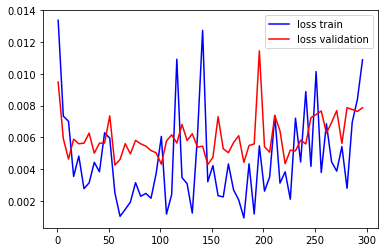

In [38]:
fig,ax=plt.subplots()
ax.plot(iteration,loss_train_list,"b",label="loss train")
ax.plot(iteration,loss_val_list,"r",label="loss validation")
ax.legend()

## Modèle 2 

In [46]:
input_dim = INPUT_SIZE   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr2 = 0.001
n_epochs = 700
iterations_per_epoch = len(trainloader)
#name_model = "model2"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=LSTM(input_size=input_dim,hidden_size=hidden_dim,output_size=output_dim)
name_model="simple_model_smalldataset_lre-3"


In [ ]:
iteration2,loss_train_list2,loss_val_list2=train(model, trainloader, valloader, lr=lr2, n_epochs=n_epochs, name_model=name_model, device=device,ite_print=2,save=True)

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 0.0017364493105560541 loss val 0.022834649309515953


/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch 3 loss train 0.003367864526808262 loss val 0.03125931695103645
epoch 5 loss train 0.0037580025382339954 loss val 0.01602192036807537
epoch 7 loss train 0.003106154967099428 loss val 0.019597183912992477
epoch 9 loss train 0.002059111837297678 loss val 0.019086359068751335
epoch 11 loss train 0.003973371349275112 loss val 0.017659468576312065
epoch 13 loss train 0.0006005298346281052 loss val 0.015559937804937363
epoch 15 loss train 0.0010138681391254067 loss val 0.01754237897694111
epoch 17 loss train 0.0011875149793922901 loss val 0.014187110587954521
epoch 19 loss train 0.002348635345697403 loss val 0.014938942156732082
epoch 21 loss train 0.0012414446100592613 loss val 0.024995267391204834
epoch 23 loss train 0.002903592074289918 loss val 0.017310097813606262
epoch 25 loss train 0.0007519221398979425 loss val 0.016581056639552116
epoch 27 loss train 0.0038874163292348385 loss val 0.012740526348352432
epoch 29 loss train 0.002675240160897374 loss val 0.014248047024011612
epoch 

epoch 229 loss train 0.00038847356336191297 loss val 0.006795933470129967
epoch 231 loss train 0.0004206483135931194 loss val 0.006938736420124769
epoch 233 loss train 0.00018238878692500293 loss val 0.006893001031130552
epoch 235 loss train 0.00021377639495767653 loss val 0.006823471747338772
epoch 237 loss train 0.0002721657801885158 loss val 0.006713616196066141
epoch 239 loss train 0.0002697106101550162 loss val 0.007358571048825979
epoch 241 loss train 0.0002024428395088762 loss val 0.006862167734652758
epoch 243 loss train 0.0002495911903679371 loss val 0.0072720847092568874
epoch 245 loss train 0.000353915587766096 loss val 0.007838916964828968
epoch 247 loss train 9.665056131780148e-05 loss val 0.006679494399577379
epoch 249 loss train 0.0003066916251555085 loss val 0.00745392357930541
epoch 251 loss train 0.0002979516866616905 loss val 0.006883930880576372
epoch 253 loss train 0.000251279299845919 loss val 0.007653999608010054
epoch 255 loss train 0.00017690617823973298 loss v

In [ ]:
fig,ax=plt.subplots()
ax.plot(iteration2,loss_train_list2,"b",label="loss train")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation")
ax.legend()

NameError: name 'iteration2' is not defined

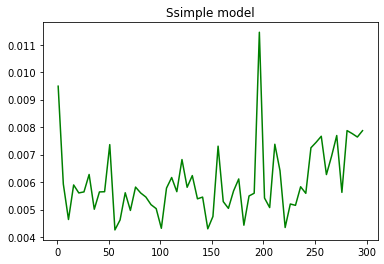

In [45]:
fig,ax=plt.subplots()
ax.set_title("Ssimple model")
ax.plot(iteration,loss_val_list,"green",label="loss validation lr 5e-2")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation lr 1e-3")
ax.legend()

In [39]:
PATH_MODEL="/Users/iris/Code/RadarTrafficData/models/simple_model_smalldataset_lr5e-2.pt"
prediction, gt, mse_list=predict(PATH_MODEL,trainloader)

In [40]:
## print(i)

In [41]:
#print(prediction)
#print(gt)

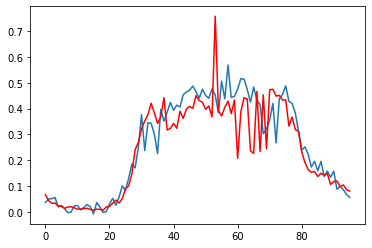

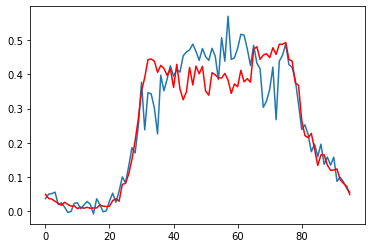

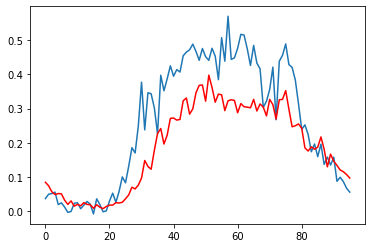

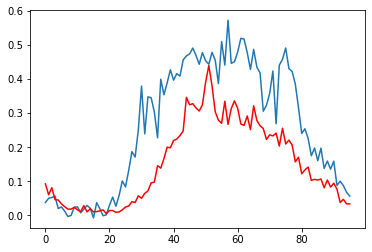

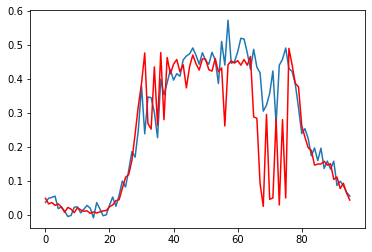

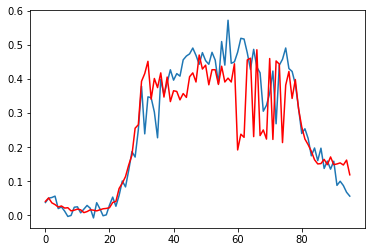

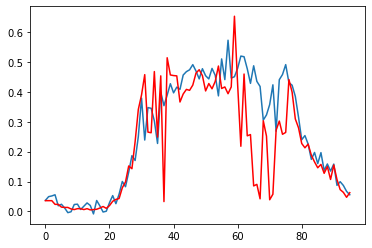

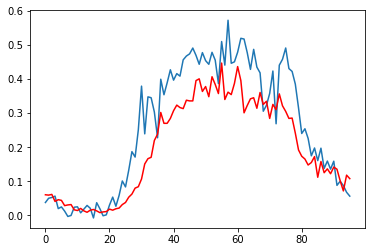

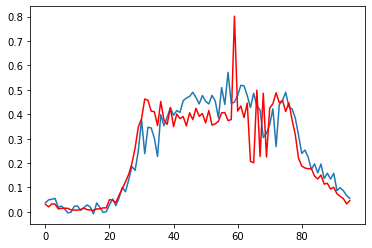

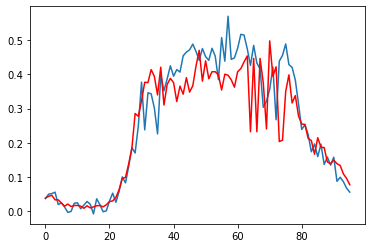

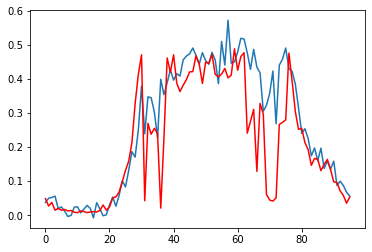

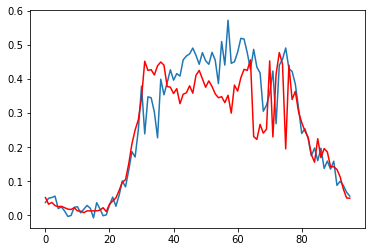

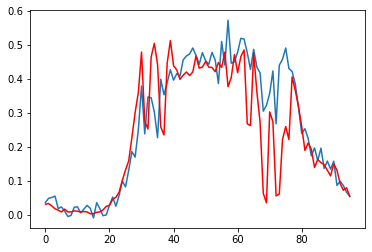

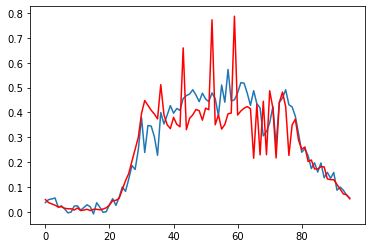

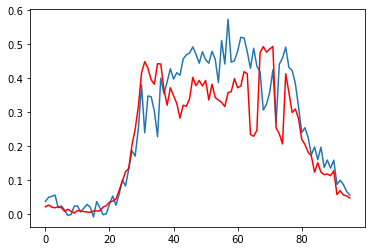

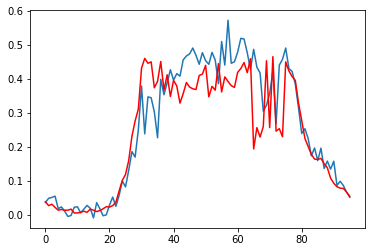

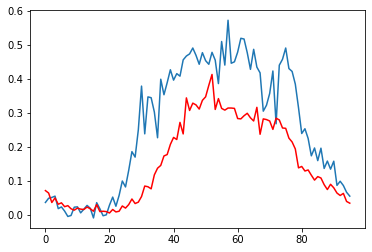

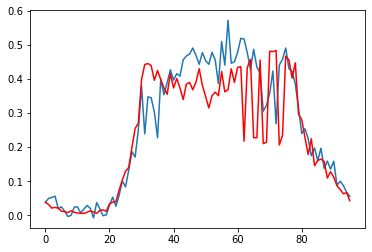

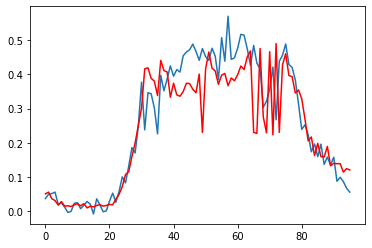

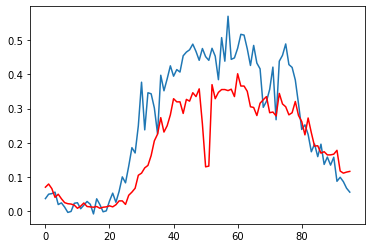

In [42]:
for i in range(20):
    fig,ax=plt.subplots()
    arr_pred=prediction[i].detach().numpy()
    ax.plot([i for i in range(len(arr_pred))],arr_pred)
    arr_gt=gt[i].detach().numpy()
    ax.plot([i for i in range(len(arr_pred))],arr_gt.ravel(),"r")

## LSTM Model

In [19]:
from encoder_decoder import lstm_wrapper

In [20]:
model_encoder_decoder=lstm_wrapper(input_size=input_dim,hidden_size=hidden_dim,target_len=output_dim)

In [19]:
model_encoder_decoder.train_model(trainloader, n_epochs=epochs, target_len=output_dim, batch_size=1, teacher_forcing_ratio=0.5,learning_rate=0.01,save=False,name_model="model")

NameError: name 'model_encoder_decoder' is not defined

In [18]:
input_dim = 1   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1
epochs=100
batch_size=1

In [19]:
model_seq2seq=lstm_seq2seq(1, hidden_dim)

In [ ]:
iteration,losses,loss_val_list=model_seq2seq.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=0.01, dynamic_tf=False,ite_print=1)

  6%|▌         | 6/100 [01:20<21:01, 13.42s/it, loss=0.267]

(96, 1, 1)
torch.Size([1, 96])


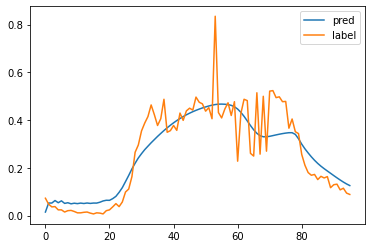

(96, 1, 1)
torch.Size([1, 96])


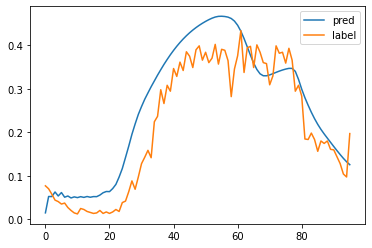

(96, 1, 1)
torch.Size([1, 96])


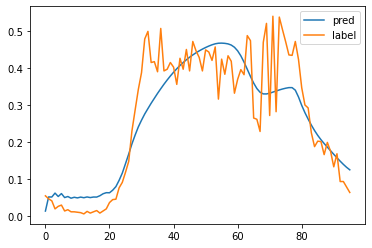

In [42]:
for seq,label in valloader:
    fig,ax=plt.subplots()
    seq_len=label.shape[1]
    pred=model_seq2seq.predict(seq,seq_len)
    print(pred.shape)
    print(label.shape)
    xpred=pred.reshape(seq_len)
    xlab=label.squeeze(0).detach().numpy()
    ax.plot([i for i in range(seq_len)],xpred,label="pred")
    ax.plot([i for i in range(seq_len)],xlab,label="label")
    ax.legend()
    plt.show()

In [33]:
print(loss_val_list)

[]


In [ ]:
iteration2,losses2,loss_val_list2=model_seq2seq.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=0.001, dynamic_tf=False,name_model="encode_decod_lre-3",save=True,ite_print=2)

In [ ]:
iteration2,losses2,loss_val_list2=model_seq2seq.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='teacher_forcing', teacher_forcing_ratio=0.5, learning_rate=0.001, dynamic_tf=False,name_model="encode_decod_lre-3",save=True,ite_print=2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
 torch.save(model_seq2seq, "../models/good_encode_decoder_i100" + ".pt")

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_seq2seq. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_decoder. It won't b